# Imports

In [127]:
import wandb
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Guide

See here for guide https://docs.wandb.ai/guides/track/public-api-guide

# Single run

In [43]:
run_id = "kn9o0vjo"
api = wandb.Api()
run = api.run("philipwastaken/02456_project/runs/" + run_id)
history = run.scan_history()

In [ ]:
train_dict = {'mean_train_reward':[],
              'frame_count': [],
              '_timestamp': []}

validate_dict = {'sims_per_val':[],
                 'avg_reward':[],
                 'duration':[],
                 'avg_frame_count':[]}

for row in history:
    print(row)
    if 'validate/sims_per_val' in row:
        validate_dict['sims_per_val'].append(row['validate/sims_per_val'])
        validate_dict['avg_reward'].append(row['validate/avg_reward'])
        validate_dict['duration'].append(row['validate/duration'])
        validate_dict['avg_frame_count'].append(row['validate/avg_frame_count'])
    else:
        train_dict['mean_train_reward'].append(row['mean_train_reward'])
        train_dict['frame_count'].append(row['frame_count'])
        train_dict['_timestamp'].append(row['_timestamp'])
        
train_df = pd.DataFrame(train_dict)
validate_df = pd.DataFrame(validate_dict)

In [45]:
train_df

,mean_train_reward,frame_count,_timestamp
0,110,132,1.669035e+09
1,70,256,1.669035e+09
2,50,322,1.669035e+09
3,80,436,1.669035e+09
4,50,494,1.669035e+09
...,...,...,...
29509,1750,7328698,1.669122e+09
29510,3550,7329108,1.669122e+09
29511,880,7329388,1.669122e+09
29512,3560,7329722,1.669122e+09


In [ ]:
validate_df

# Multiple Runs

In [2]:
api = wandb.Api() 
runs = api.runs("philipwastaken/02456_project")

### Get runs with proper hyperparameters

In [111]:
good_runs = []
for i, run in enumerate(runs): 
    
    conf = run.config['update']
    if  conf['learning_rate']==0.0003 and conf['replay_memory_capacity']==50000 and conf['batch_size']==32:
        status = str(run)[44:-2]
        if status == 'finished':
            good_runs.append(i)
            print(i, conf)

6 {'tau': 0.01, 'gamma': 0.99, 'val_freq': 1, 'batch_size': 32, 'num_episodes': 20000, 'weight_decay': 0, 'episode_limit': 10000, 'learning_rate': 0.0003, 'prefill_memory': True, 'replay_memory_capacity': 50000}
7 {'tau': 0.01, 'gamma': 0.99, 'val_freq': 1, 'batch_size': 32, 'num_episodes': 20000, 'weight_decay': 0, 'episode_limit': 10000, 'learning_rate': 0.0003, 'prefill_memory': True, 'replay_memory_capacity': 50000}
8 {'tau': 0.01, 'gamma': 0.99, 'val_freq': 1, 'batch_size': 32, 'num_episodes': 20000, 'weight_decay': 0, 'episode_limit': 10000, 'learning_rate': 0.0003, 'prefill_memory': True, 'replay_memory_capacity': 50000}
9 {'tau': 0.01, 'gamma': 0.99, 'val_freq': 1, 'batch_size': 32, 'num_episodes': 20000, 'weight_decay': 0, 'episode_limit': 10000, 'learning_rate': 0.0003, 'prefill_memory': True, 'replay_memory_capacity': 50000}
10 {'tau': 0.01, 'gamma': 0.99, 'val_freq': 1, 'batch_size': 32, 'num_episodes': 20000, 'weight_decay': 0, 'episode_limit': 10000, 'learning_rate': 0.00

### Split runs into each model/wrapper

In [186]:
models_id = {
    'gray' : [],
    'crop' : [],
    'scale120' : [],
    'scale84' : [],
    'scale72' : [],
    #'scale60' : [],
    #'scale48' : [],
}
for i, run in enumerate(runs): 
    if i in good_runs:
        summ = run.summary
        model = summ['model_path'][40:-38]
        models_id[model].append(i)
models_id

{'gray': [15, 34],
 'crop': [9, 18, 19, 33],
 'scale120': [6, 10, 20, 32],
 'scale84': [7, 11, 12, 21, 29, 35],
 'scale72': [8, 13, 14, 22, 36, 42]}

## Collect reward/performance data

In [122]:
train = {}
validate = {}

for i, run in enumerate(runs):
    
    if i not in good_runs:
        continue
        
    history = run.scan_history()
    
    train[i] = []
    validate[i] = []
    for row in history:
        try:
            if 'validate/sims_per_val' in row:
                validate[i].append(row['validate/avg_reward'])
            else:
                train[i].append(row['mean_train_reward'])
        except:
            print(row)

## Visualize multiple TRAIN runs of SAME wrapper

In [ ]:
ids = models_id['scale72']
print(ids)
for id in ids:
    plt.plot(pd.Series(train[id][:20000]).rolling(4000).mean() )
plt.show()

## Visualize multiple VALIDATION runs of SAME wrapper

[7, 11, 12, 21, 29, 35]


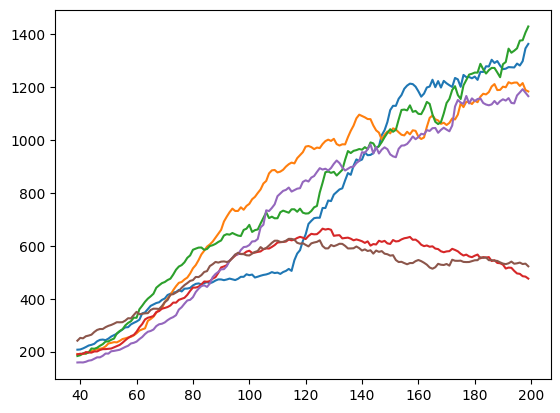

In [214]:
ids = models_id['scale84']
print(ids)
for id in ids:
    plt.plot(pd.Series(validate[id][:200]).rolling(40).mean())
    #plt.plot(pd.Series(validate[id][:20000]).rolling(4000).mean() )
plt.show()

## Visualize mean TRAIN run of wrappers

gray
crop
scale120
scale84
scale72


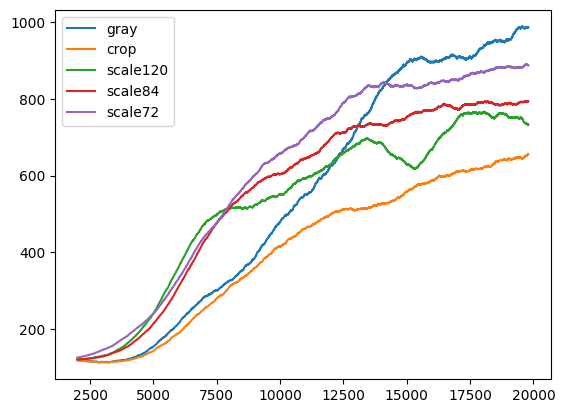

In [200]:
for model in models_id:
    print(model)
    arr = []
    for id in models_id[model]:
        arr.append(train[id][:19800])
    mean = np.array(arr).mean(axis=0)
    MA = pd.Series(mean).rolling(2000).mean()
    plt.plot(MA)

plt.legend(models_id.keys())
plt.show()

## Visualize mean VALIDATION run of wrappers

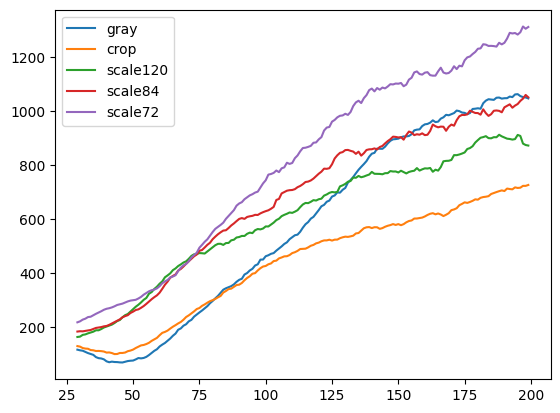

In [218]:
for model in models_id:
    arr = []
    for id in models_id[model]:
        arr.append(validate[id][:200])
    mean = np.array(arr).mean(axis=0)
    MA = pd.Series(mean).rolling(30).mean()
    plt.plot(MA)

plt.legend(models_id.keys())
plt.show()